In [13]:
import os, glob, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import welch, hilbert
from scipy.stats import skew, kurtosis
import pywt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from config.config import DataConfig

FEATURE EXCTRACTION

In [3]:
def bandpower_welch(signal, fs, band):
    """
    Computes power in a frequency band using Welch's method.
    band = (low_freq, high_freq)
    Returns sum of PSD in that band.
    """
    f, Pxx = welch(signal, fs=fs, nperseg=256)  # Adjust nperseg if needed
    # Identify indices within the band
    idx = np.logical_and(f >= band[0], f <= band[1])
    return np.sum(Pxx[idx])

def compute_features(signal, fs=200):
    """
    Given a 2-second window (signal) at 200 Hz,
    compute various features:
      1) PSD in delta, theta, alpha, beta, gamma bands
      2) Statistical moments: mean, variance, skewness, kurtosis
      3) Wavelet-based feature (energy across a few scales)
      4) Amplitude envelope (Hilbert) mean
    Returns a dict of features.
    """
    # 1) PSD-based bandpowers
    # Common EEG bands (approx): delta(0.5-4), theta(4-8), alpha(8-12), beta(12-30), gamma(30-50)
    bands = {
        "delta": (0.5, 4),
        "theta": (4, 8),
        "alpha": (8, 12),
        "beta":  (12, 30),
        "gamma": (30, 50),
    }
    psd_feats = {}
    for bname, (lowf, highf) in bands.items():
        psd_feats[f"psd_{bname}"] = bandpower_welch(signal, fs, (lowf, highf))

    # 2) Statistical moments
    mean_val = np.mean(signal)
    var_val  = np.var(signal)
    skew_val = skew(signal)
    kurt_val = kurtosis(signal)

    # 3) Wavelet-based feature
    # We'll do a simple discrete wavelet transform and compute the sum of squared coeffs at each level
    # This is just one example; real EEG wavelet analysis can be more advanced.
    coeffs = pywt.wavedec(signal, 'db4', level=3)  # wavelet 'db4', 3 levels
    # sum of squares of each level's coefficients as a simple measure of wavelet energy
    wavelet_energies = [np.sum(c**2) for c in coeffs]
    # Flatten them into separate features
    wavelet_feats = {}
    for i, en in enumerate(wavelet_energies):
        wavelet_feats[f"wavelet_energy_level{i}"] = en

    # 4) Amplitude envelope (Hilbert transform)
    analytic_sig = hilbert(signal)
    amp_env = np.abs(analytic_sig)
    mean_amp = np.mean(amp_env)

    # Combine all features into a dict
    feats = {}
    feats.update(psd_feats)
    feats.update({
        "stat_mean": mean_val,
        "stat_var": var_val,
        "stat_skew": skew_val,
        "stat_kurt": kurt_val,
    })
    feats.update(wavelet_feats)
    feats["hilbert_mean_amp"] = mean_amp
    return feats

In [ ]:
# data_dir = "/Users/tereza/spring_2025/STAT_4830/STAT-4830-GOALZ-project/data/ANPHY-Sleep_data"
data_dir = DataConfig.BASE_PATH
pkl_files = glob.glob(os.path.join(data_dir, "EPCTL*", "extracted_windows_group*.pkl"))

all_rows = []
for pkl_file in pkl_files:
    with open(pkl_file, "rb") as f:
        windows_dict = pickle.load(f)
    for key, val in windows_dict.items():
        # key e.g. "epctl18_w_win_1_P1Ref"
        parts = key.split("_")
        subject = parts[0]            # "epctl18"
        stage = parts[1]             # "w" or "n1"
        # parts[2] = "win"
        window_num = parts[3]        # "1"
        electrode = parts[4]         # "P1Ref" etc.
        
        time_index = val["time_index"]
        signal = val["window"]  # shape ~ (400,)

        # Compute features for this signal
        feats = compute_features(signal, fs=200)
        # Build row
        row = {
            "subject": subject,
            "stage": stage,
            "window_num": window_num,
            "electrode": electrode,
            "time_index": time_index,
        }
        row.update(feats)
        all_rows.append(row)

# Create a DataFrame of all features
df = pd.DataFrame(all_rows)
print("Created DataFrame with shape:", df.shape)
print("Columns:", df.columns)

# Separate out metadata columns vs. numeric feature columns
meta_cols = ["subject", "stage", "window_num", "electrode", "time_index"]
feature_cols = [c for c in df.columns if c not in meta_cols]

# Normalize (standardize) the numeric feature columns
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[feature_cols] = scaler.fit_transform(df[feature_cols])

Created DataFrame with shape: (540, 19)
Columns: Index(['subject', 'stage', 'window_num', 'electrode', 'time_index',
       'psd_delta', 'psd_theta', 'psd_alpha', 'psd_beta', 'psd_gamma',
       'stat_mean', 'stat_var', 'stat_skew', 'stat_kurt',
       'wavelet_energy_level0', 'wavelet_energy_level1',
       'wavelet_energy_level2', 'wavelet_energy_level3', 'hilbert_mean_amp'],
      dtype='object')


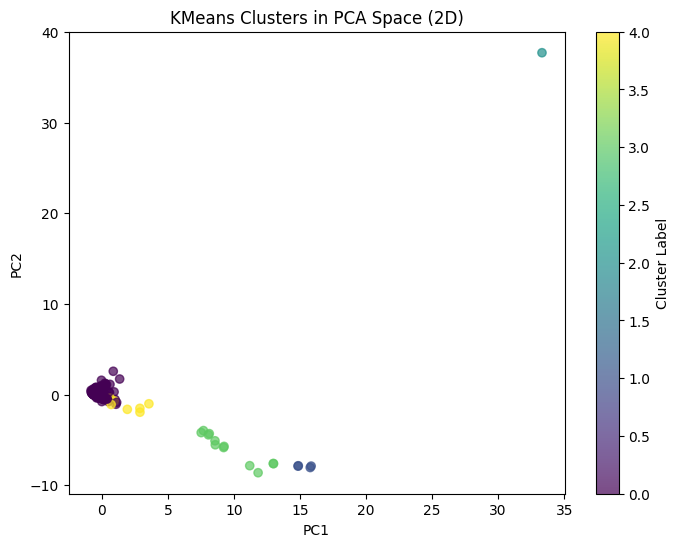

Done. DataFrame 'df' (and 'df_scaled') now contains features for all windows.


In [5]:
# KMeans and a PCA 2D plot
X = df_scaled[feature_cols].values
# kmeans = KMeans(n_clusters=2, random_state=0)
kmeans = KMeans(n_clusters=5, random_state=0)
cluster_labels = kmeans.fit_predict(X)

# Add cluster labels to DataFrame
df_scaled["cluster"] = cluster_labels

# PCA for 2D visualization
# pca = PCA(n_components=2, random_state=0)
pca = PCA(n_components=5, random_state=0)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=cluster_labels, cmap="viridis", alpha=0.7)
plt.title("KMeans Clusters in PCA Space (2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Cluster Label")
plt.show()

print("Done. DataFrame 'df' (and 'df_scaled') now contains features for all windows.")

CLASSIFICATION

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [7]:
# import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Assume df is your DataFrame with all extracted features.
print("DataFrame shape:", df.shape)

all_subjects = np.sort(df["subject"].unique())
n_train = int(0.7 * len(all_subjects))
train_subjects = all_subjects[:n_train]
test_subjects  = all_subjects[n_train:]
print("Train subjects:", train_subjects)
print("Test subjects:", test_subjects)

train_df = df[df["subject"].isin(train_subjects)].copy()
test_df  = df[df["subject"].isin(test_subjects)].copy()

meta_cols = ["subject", "stage", "window_num", "electrode", "time_index"]
feature_cols = [c for c in df.columns if c not in meta_cols]

X_train = train_df[feature_cols].values
X_test  = test_df[feature_cols].values

le = LabelEncoder()
y_train = le.fit_transform(train_df["stage"].values)
y_test  = le.transform(test_df["stage"].values)

DataFrame shape: (540, 19)
Train subjects: ['epctl01' 'epctl02' 'epctl03' 'epctl04' 'epctl05' 'epctl06' 'epctl07'
 'epctl08' 'epctl09' 'epctl10' 'epctl11' 'epctl12' 'epctl13' 'epctl14'
 'epctl15' 'epctl16' 'epctl17' 'epctl18' 'epctl19' 'epctl20']
Test subjects: ['epctl21' 'epctl22' 'epctl23' 'epctl24' 'epctl25' 'epctl26' 'epctl27'
 'epctl28' 'epctl29']


Logistic Regression Classification Report:
              precision    recall  f1-score   support

          n1       0.57      0.70      0.63        81
           w       0.61      0.47      0.53        81

    accuracy                           0.59       162
   macro avg       0.59      0.59      0.58       162
weighted avg       0.59      0.59      0.58       162

Confusion Matrix:
[[57 24]
 [43 38]]


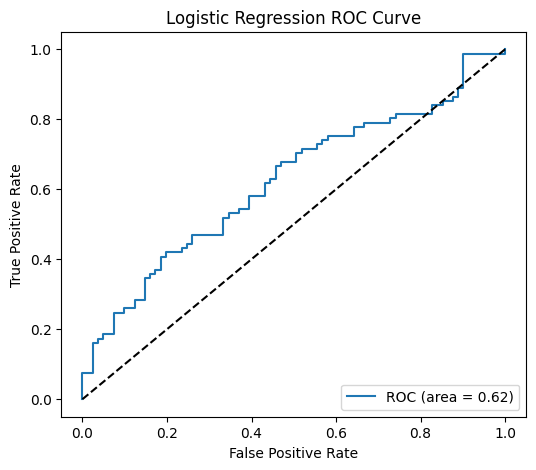

In [8]:
pipe_lr = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(random_state=0, max_iter=1000))
])
pipe_lr.fit(X_train, y_train)
y_pred_lr = pipe_lr.predict(X_test)

print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr, target_names=le.classes_))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr))

if hasattr(pipe_lr.named_steps["clf"], "predict_proba"):
    y_prob_lr = pipe_lr.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob_lr)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label="ROC (area = {:.2f})".format(roc_auc))
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Logistic Regression ROC Curve")
    plt.legend(loc="lower right")
    plt.show()

SVM Classification Report:
              precision    recall  f1-score   support

          n1       0.61      0.74      0.67        81
           w       0.67      0.52      0.58        81

    accuracy                           0.63       162
   macro avg       0.64      0.63      0.62       162
weighted avg       0.64      0.63      0.62       162

Confusion Matrix:
[[60 21]
 [39 42]]


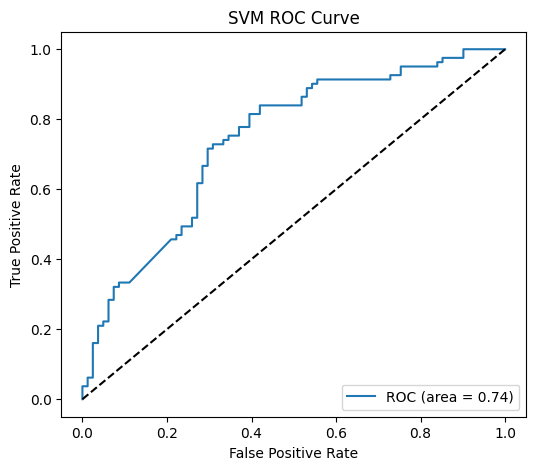

In [10]:
pipe_svm = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", SVC(probability=True, random_state=0))
])
pipe_svm.fit(X_train, y_train)
y_pred_svm = pipe_svm.predict(X_test)

print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm, target_names=le.classes_))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm))

if hasattr(pipe_svm.named_steps["clf"], "predict_proba"):
    y_prob_svm = pipe_svm.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob_svm)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label="ROC (area = {:.2f})".format(roc_auc))
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("SVM ROC Curve")
    plt.legend(loc="lower right")
    plt.show()

Random Forest Classification Report:
              precision    recall  f1-score   support

          n1       0.81      0.74      0.77        81
           w       0.76      0.83      0.79        81

    accuracy                           0.78       162
   macro avg       0.79      0.78      0.78       162
weighted avg       0.79      0.78      0.78       162

Confusion Matrix:
[[60 21]
 [14 67]]


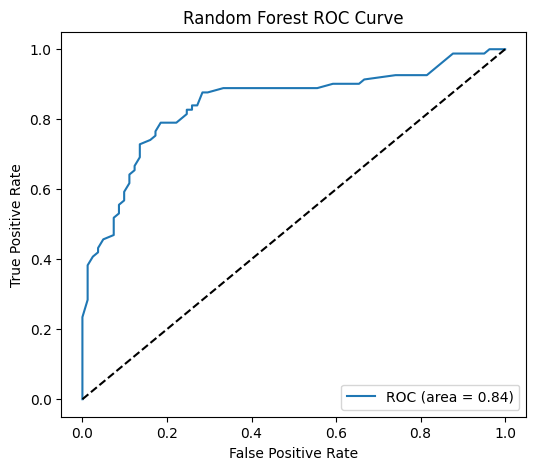

In [12]:
pipe_rf = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", RandomForestClassifier(random_state=0, n_estimators=100))
])
pipe_rf.fit(X_train, y_train)
y_pred_rf = pipe_rf.predict(X_test)

print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=le.classes_))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

if hasattr(pipe_rf.named_steps["clf"], "predict_proba"):
    y_prob_rf = pipe_rf.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob_rf)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label="ROC (area = {:.2f})".format(roc_auc))
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Random Forest ROC Curve")
    plt.legend(loc="lower right")
    plt.show()